In [136]:
import os.path
from math import ceil, floor

import numpy as np
import pandas as pd
from matplotlib.ticker import FixedLocator

from src.tools.file import store_plt
from src.tools.la import fixed_fixed
from src.tools.plotter import init_plots, store_sns
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType, Pollution
from src.trace_set.set_hw import TraceSetHW

import seaborn as sns

from src.tvla.cri import tvla_t_test

init_plots()

In [137]:
TRACE_SET = TraceSetHW(Database.aisy)
TRACE_SET_DESYNC = TraceSetHW(Database.aisy, Pollution(PollutionType.desync, 450))
TRACE_SET_GAUSS = TraceSetHW(Database.aisy, Pollution(PollutionType.gauss, 1500))

X, Y = fixed_fixed(*TRACE_SET.all())
X_DESYNC, _ = fixed_fixed(*TRACE_SET_DESYNC.all())
X_GAUSS, _ = fixed_fixed(*TRACE_SET_GAUSS.all())

A, B = X[~Y], X[Y]
A_DESYNC, B_DESYNC = X_DESYNC[~Y], X_DESYNC[Y]
A_GAUSS, B_GAUSS = X_GAUSS[~Y], X_GAUSS[Y]

PVS = tvla_t_test(X, Y, max_order=1, progress=False)[1]
PVS_DESYNC = tvla_t_test(X_DESYNC, Y, max_order=1, progress=False)[1]
PVS_GAUSS = tvla_t_test(X_GAUSS, Y, max_order=1, progress=False)[1]

In [138]:
DLLA_PALETTE = sns.light_palette(sns.color_palette()[0], n_colors=5)
TVLA_PALETTE = sns.light_palette(sns.color_palette()[1], n_colors=5)
GE_PALETTE = sns.light_palette(sns.color_palette()[2], n_colors=5)

THRESHOLD_COLOR = "#FF000080"

METHODS = {
    "dlla_open": ("DL-LA 9 class ($p$)", DLLA_PALETTE[3], "-"),
    "dlla_closed": ("DL-LA closed-source", DLLA_PALETTE[2], "-"),
    "dlla_wegener": ("Wegener DL-LA ($p$)", DLLA_PALETTE[1], "-"),
    # "tvla_t_1": ("TVLA $t$-test, $\mu_1$ ($p$)", TVLA_PALETTE[3], "--"),
    # "tvla_t_2": ("TVLA $t$-test, $\mu_2$ ($p$)", TVLA_PALETTE[2], "--"),
    # "tvla_rho": ("TVLA $\\rho$-test ($p$)", TVLA_PALETTE[1], "--"),
    "sca_hw": ("Profiled SCA", GE_PALETTE[3], "--"),
}

TITLES = {
    Database.ascad: {
        PollutionType.gauss: "SCA against LA under different levels of Gaussian noise\n1000 traces, ASCAD Database (Masked)",
        PollutionType.desync: "SCA against LA under different levels of Window jitter\n1000 traces, ASCAD Database (Masked)"
    },
    Database.ascad_none: {
        PollutionType.gauss: "SCA against LA under different levels of Gaussian noise\n1000 traces, ASCAD Database (Unprotected)",
        PollutionType.desync: "SCA against LA under different levels of Window jitter\n1000 traces, ASCAD Database (Unprotected)"
    }
}

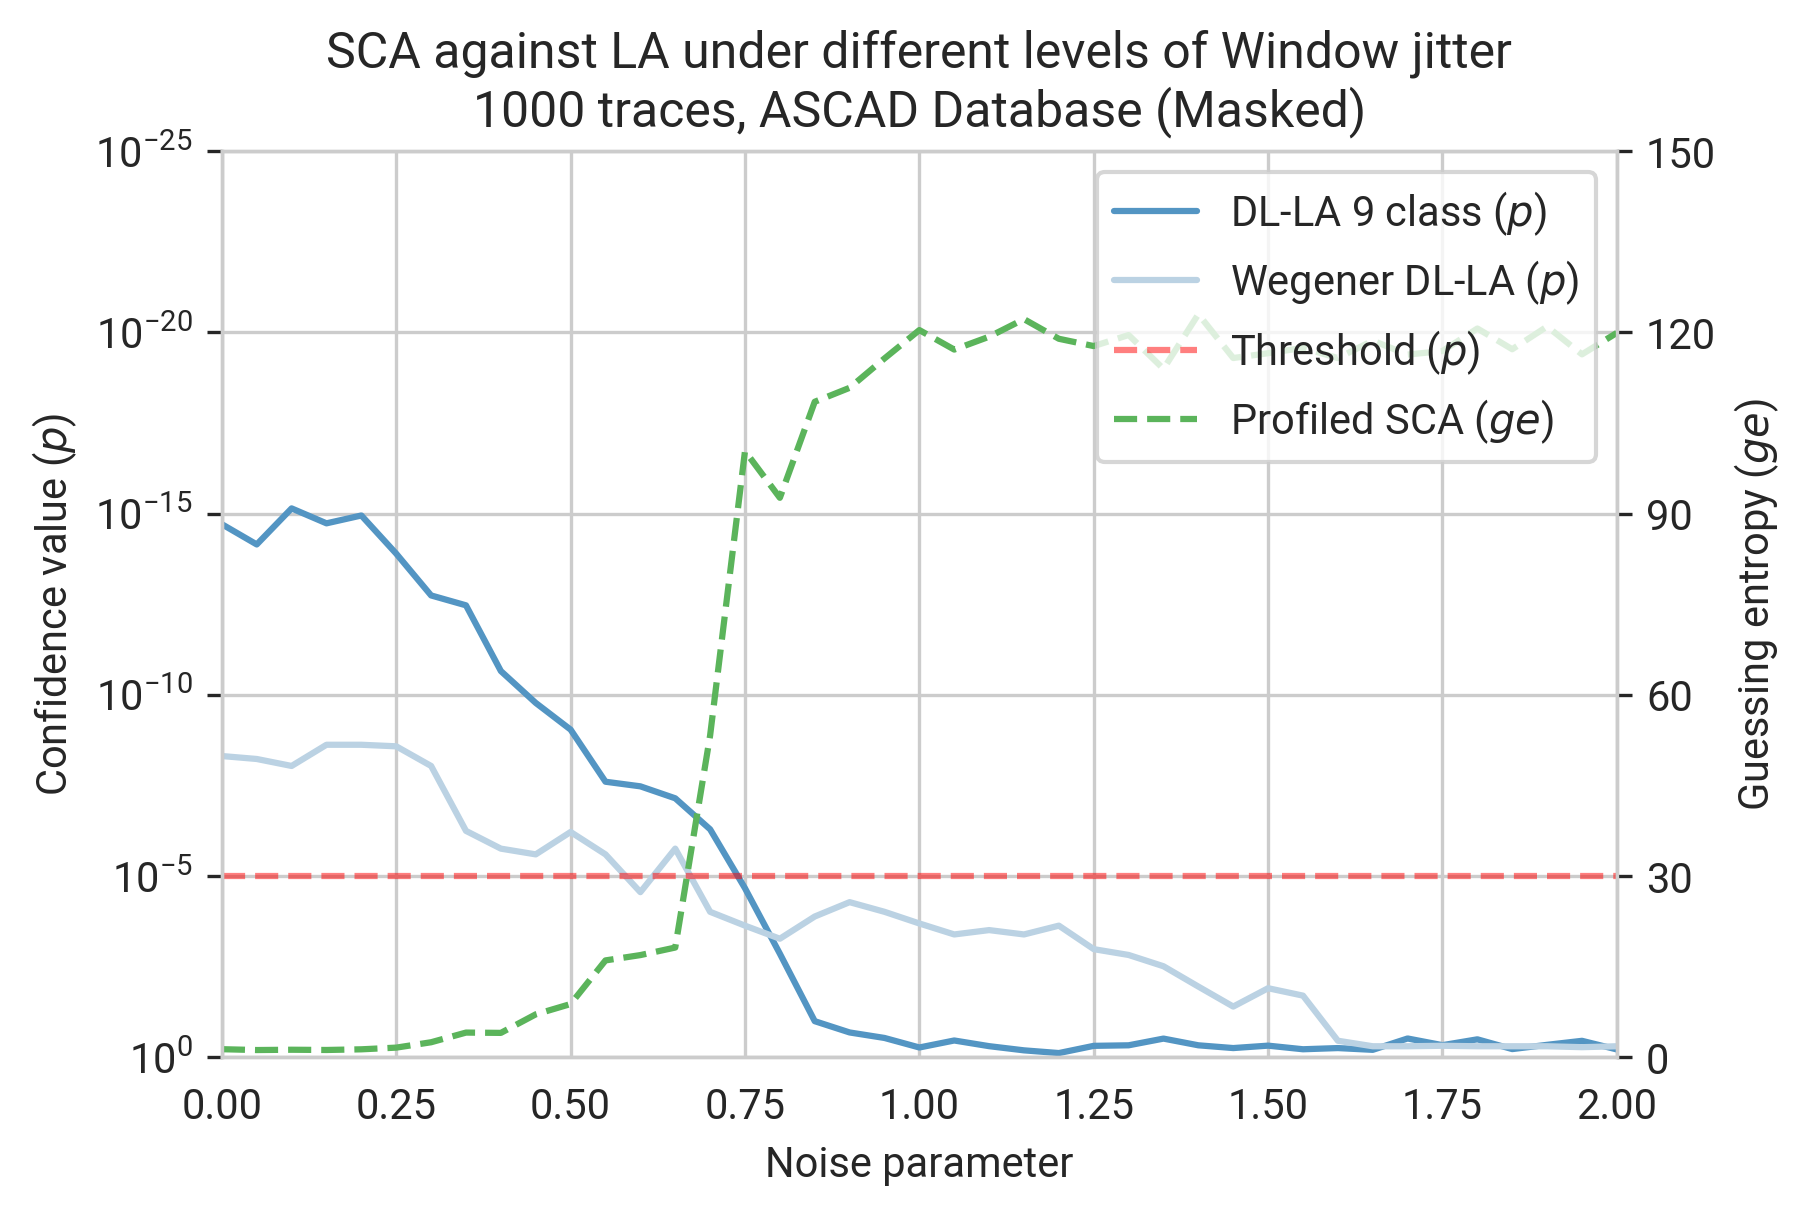

In [139]:
def combine(p, v):
    # Balance y-ticks
    p_lim, v_lim = p.get_ylim(), v.get_ylim()
    p_lim_log = np.abs(np.log10(p_lim).astype(int))[1]
    p_step_size = p_lim_log / 5

    p_ticks = np.arange(0, p_lim_log + p_step_size, p_step_size)

    v_step_size = len(p_ticks)
    v_ticks = np.linspace(*v_lim, v_step_size)

    p.yaxis.set_major_locator(FixedLocator(10. ** (-p_ticks)))
    v.yaxis.set_major_locator(FixedLocator(v_ticks))

    # Combine legends
    handles1, labels1 = p.get_legend_handles_labels()
    handles2, labels2 = v.get_legend_handles_labels()
    p.get_legend().remove()
    v.legend(handles1 + handles2, labels1 + labels2, loc="upper right")

    # Remove grid, overlaying p-graphs
    v.grid(False)

def plot(db, poll_type, x_max=np.inf, ge=True):
    df = pd.read_csv(f"../3-performance/noise/results_{db.name}.csv", sep=";")
    df = df[df.pollution == poll_type.name].drop(columns=[df.pollution.name])

    gdf = df.groupby(df.method)

    g = None
    for method, (label, color, style) in METHODS.items():
        if method in gdf.groups:
            method_group = gdf.get_group(method)
            med = method_group.groupby(df.param).median()
            pvs = med.p

            if min(pvs) < 10 ** -5:
                g = sns.lineplot(x=med.param, y=pvs, label=label, color=color, linestyle=style)

    xlim = g.get_xlim()
    x_max = min(x_max, xlim[1])
    t_line = [10 ** -5] * (round(x_max) + 1)
    g = sns.lineplot(data=t_line, label="Threshold ($p$)", color=THRESHOLD_COLOR, linestyle="--")
    g.set(ylim=(1, 10 ** -25), yscale="log", xlim=(0, floor(x_max)), xlabel="Noise parameter", ylabel="Confidence value ($p$)")

    df_sca = pd.read_csv(f"results/{db.name}.csv", sep=";")
    df_sca = df_sca[df_sca.pollution == poll_type.name].drop(columns=[df_sca.pollution.name])

    g2 = g.twinx()
    gdf_sca = df_sca.groupby(df_sca.method)
    ylabel = "Guessing entropy ($ge$)"
    ylim = (0, 150)
    for method, (label, color, style) in METHODS.items():
        # print(gdf_sca.groups)

        if method in gdf_sca.groups:
            method_group = gdf_sca.get_group(method)
            med = method_group.groupby(df_sca.param).median()
            if ge:
                label += " ($ge$)"
                sns.lineplot(x=med.param, y=med.kr, label=label, color=color, linestyle=style)
            else:
                label += " ($sr$)"
                ylabel = "Success rate ($sr$)"
                ylim = (0, 1)
                sns.lineplot(x=med.param, y=med.sr, label=label, color=color, linestyle=style)

    g2.set(ylim=ylim, xlim=(0, floor(x_max)), ylabel=ylabel, title=TITLES[db][poll_type])

    combine(g, g2)

    return g

G = plot(Database.ascad, PollutionType.desync, 2)

store_sns(G, "sca-ge-ascad-desync")

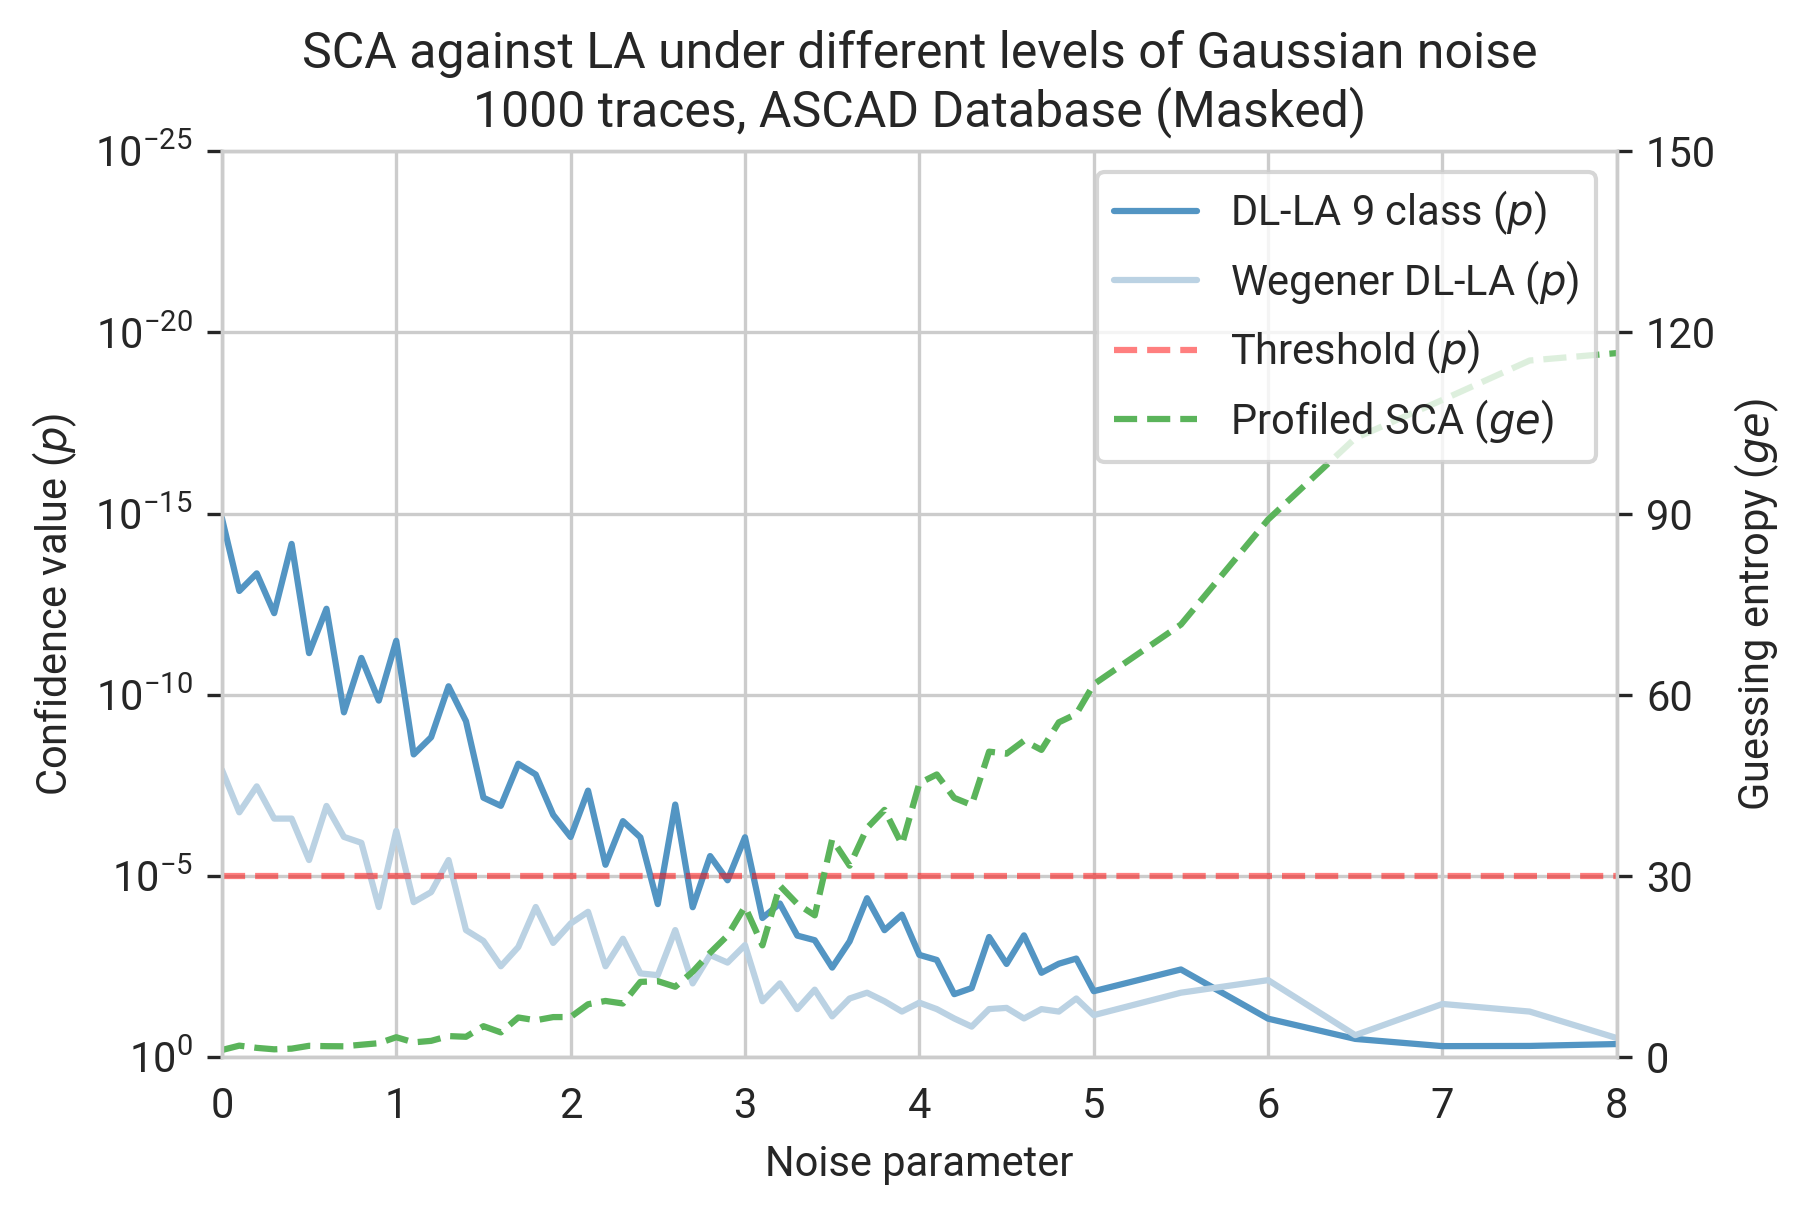

In [140]:
G = plot(Database.ascad, PollutionType.gauss, 8)

store_sns(G, "sca-ge-ascad-gauss")

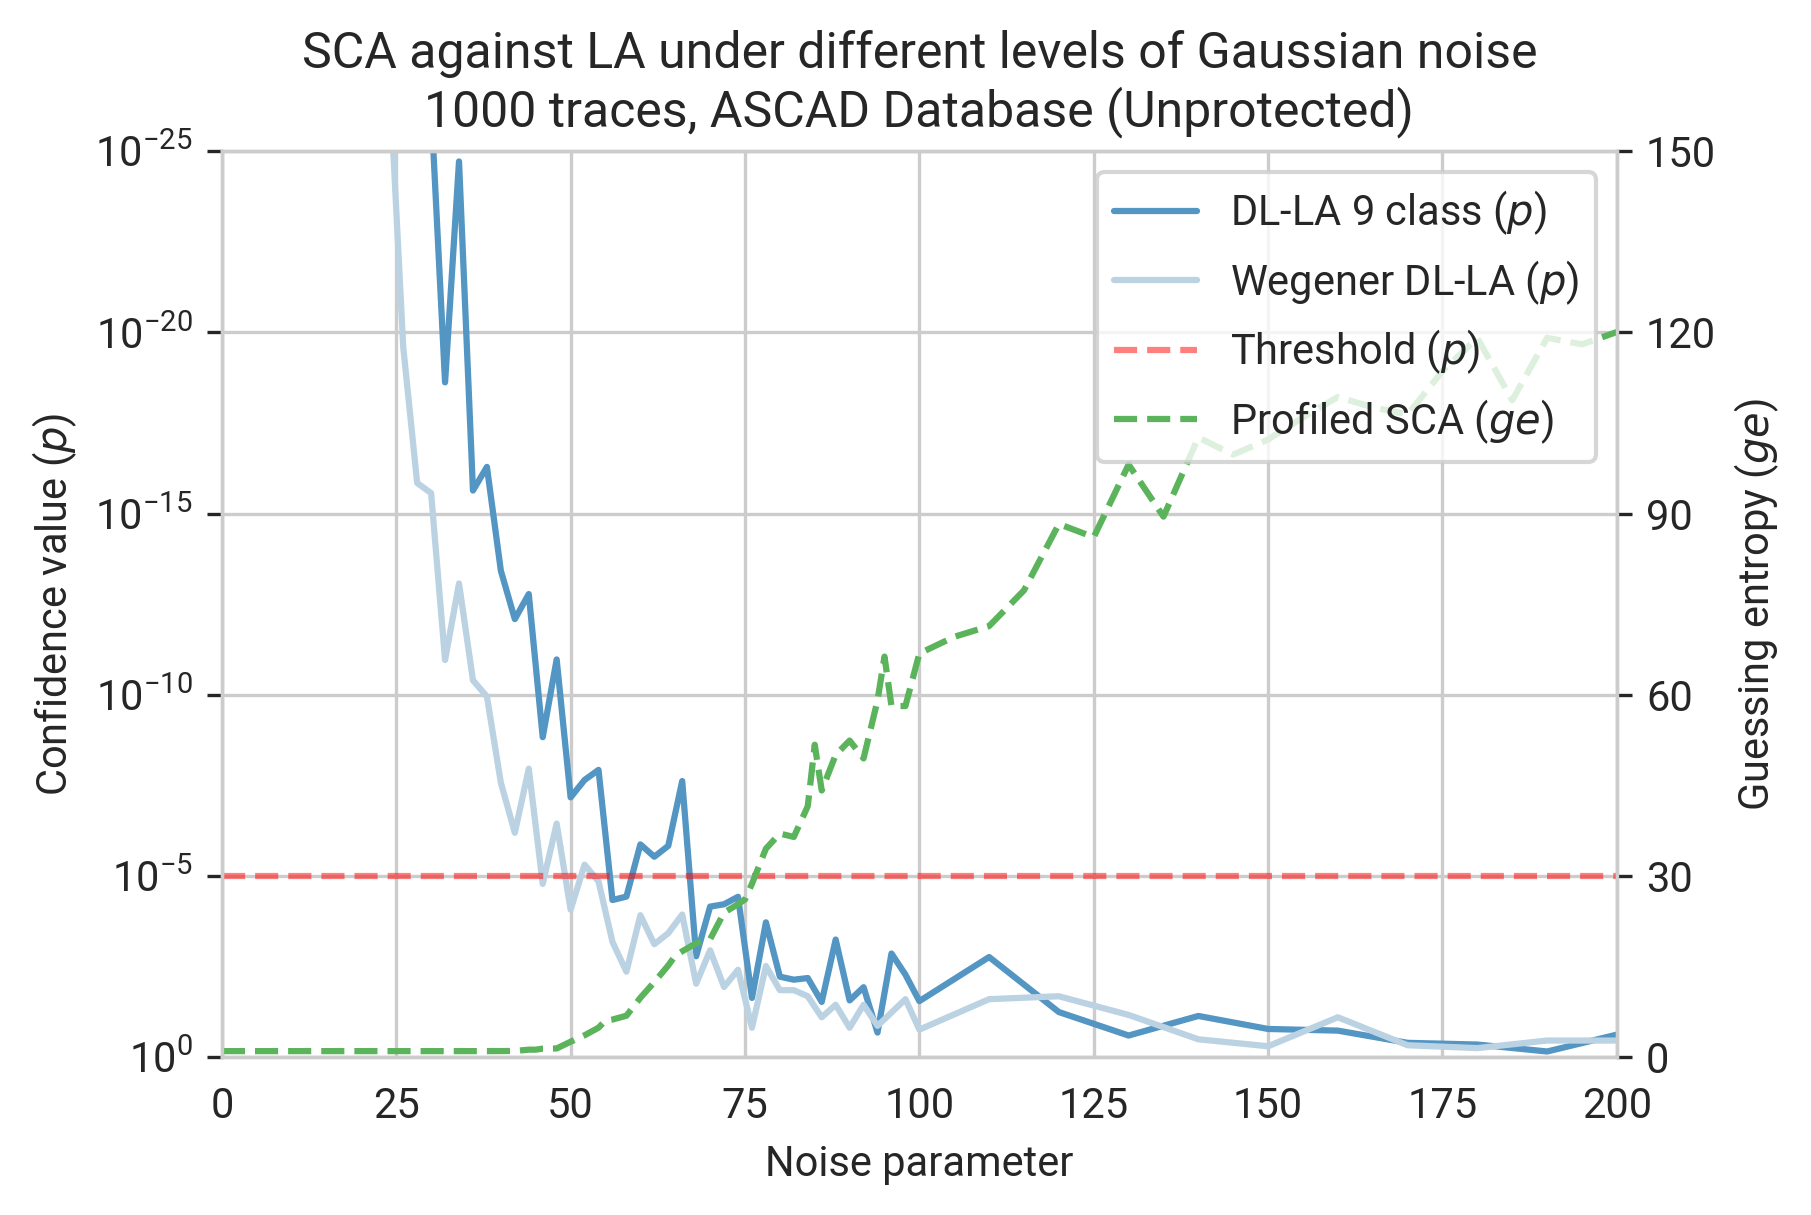

In [141]:
G = plot(Database.ascad_none, PollutionType.gauss, 200)

store_sns(G, "sca-ge-ascad-none-gauss")

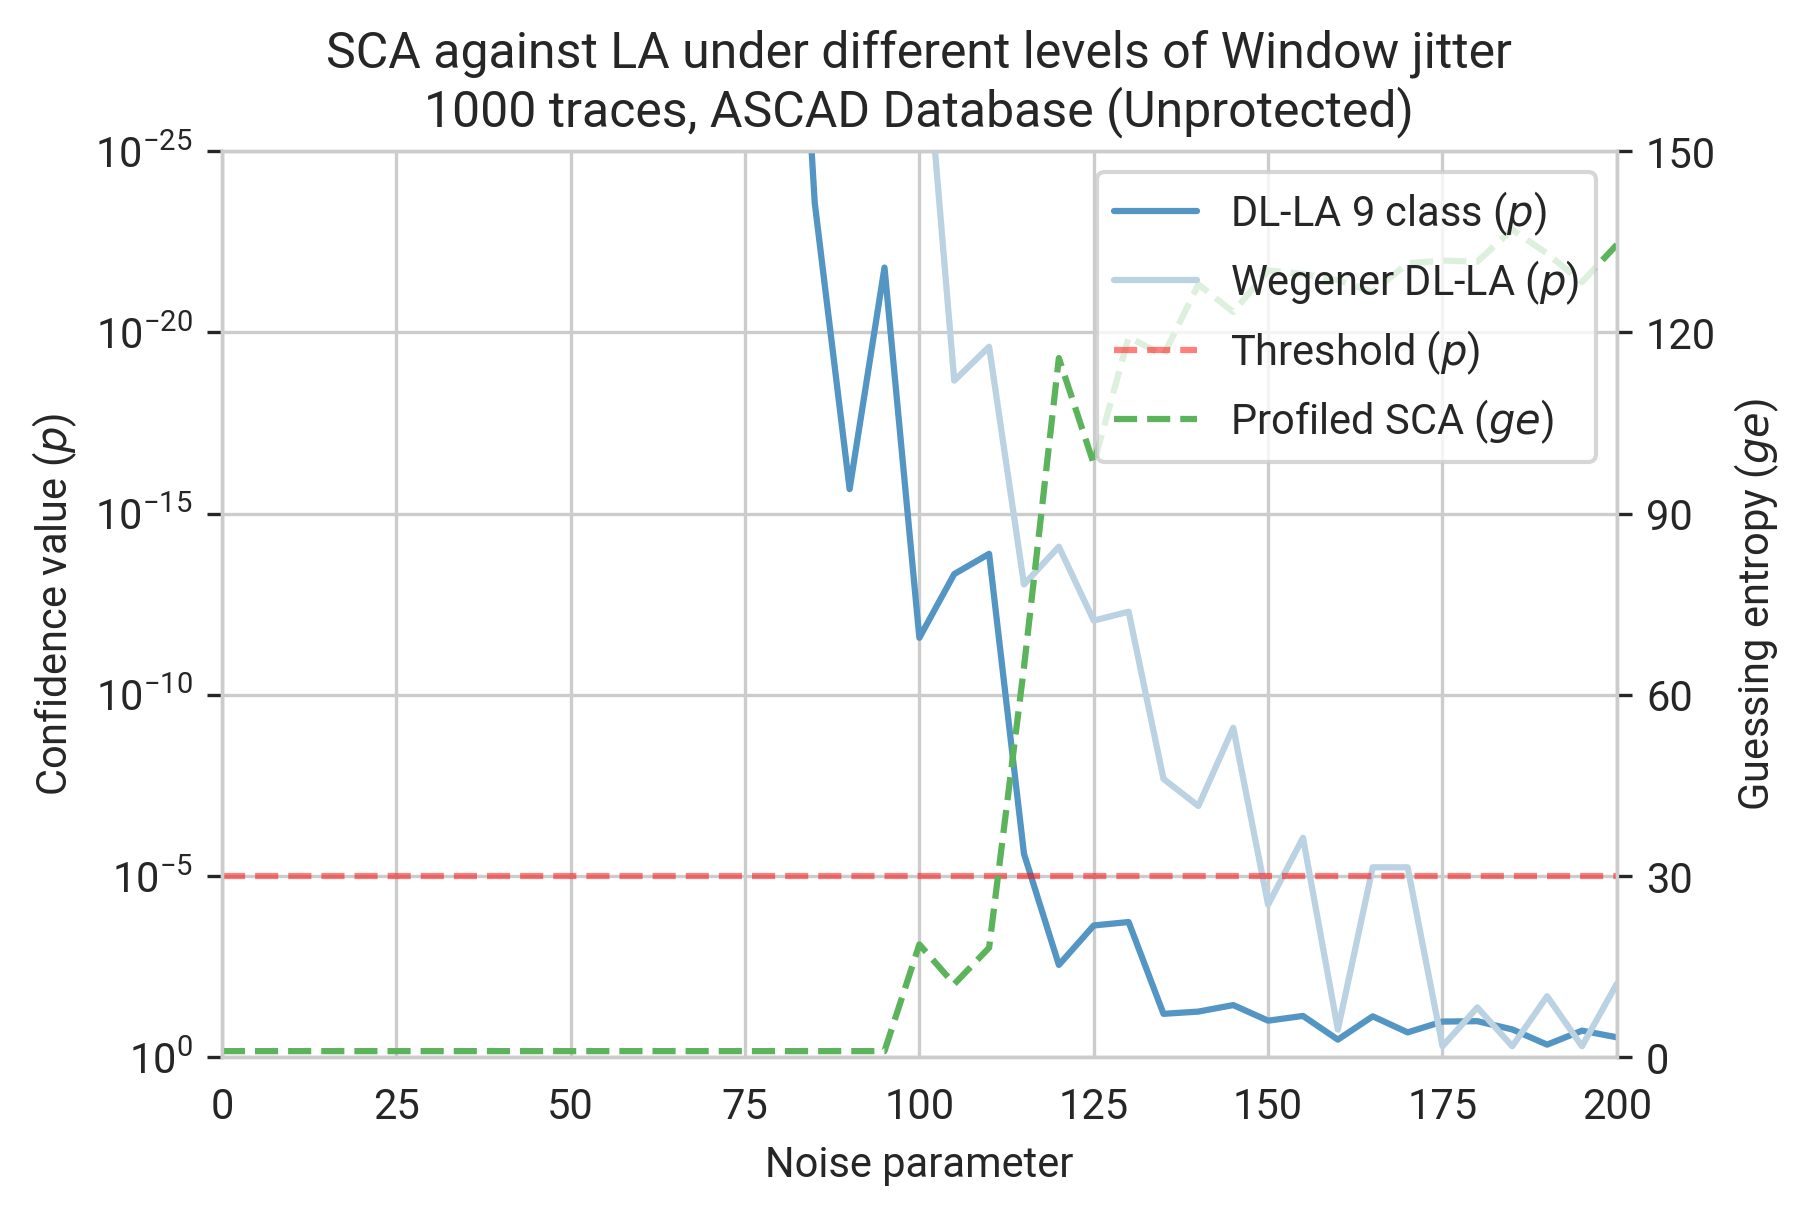

In [142]:
G = plot(Database.ascad_none, PollutionType.desync, 200)

store_sns(G, "sca-ge-ascad-none-desync")

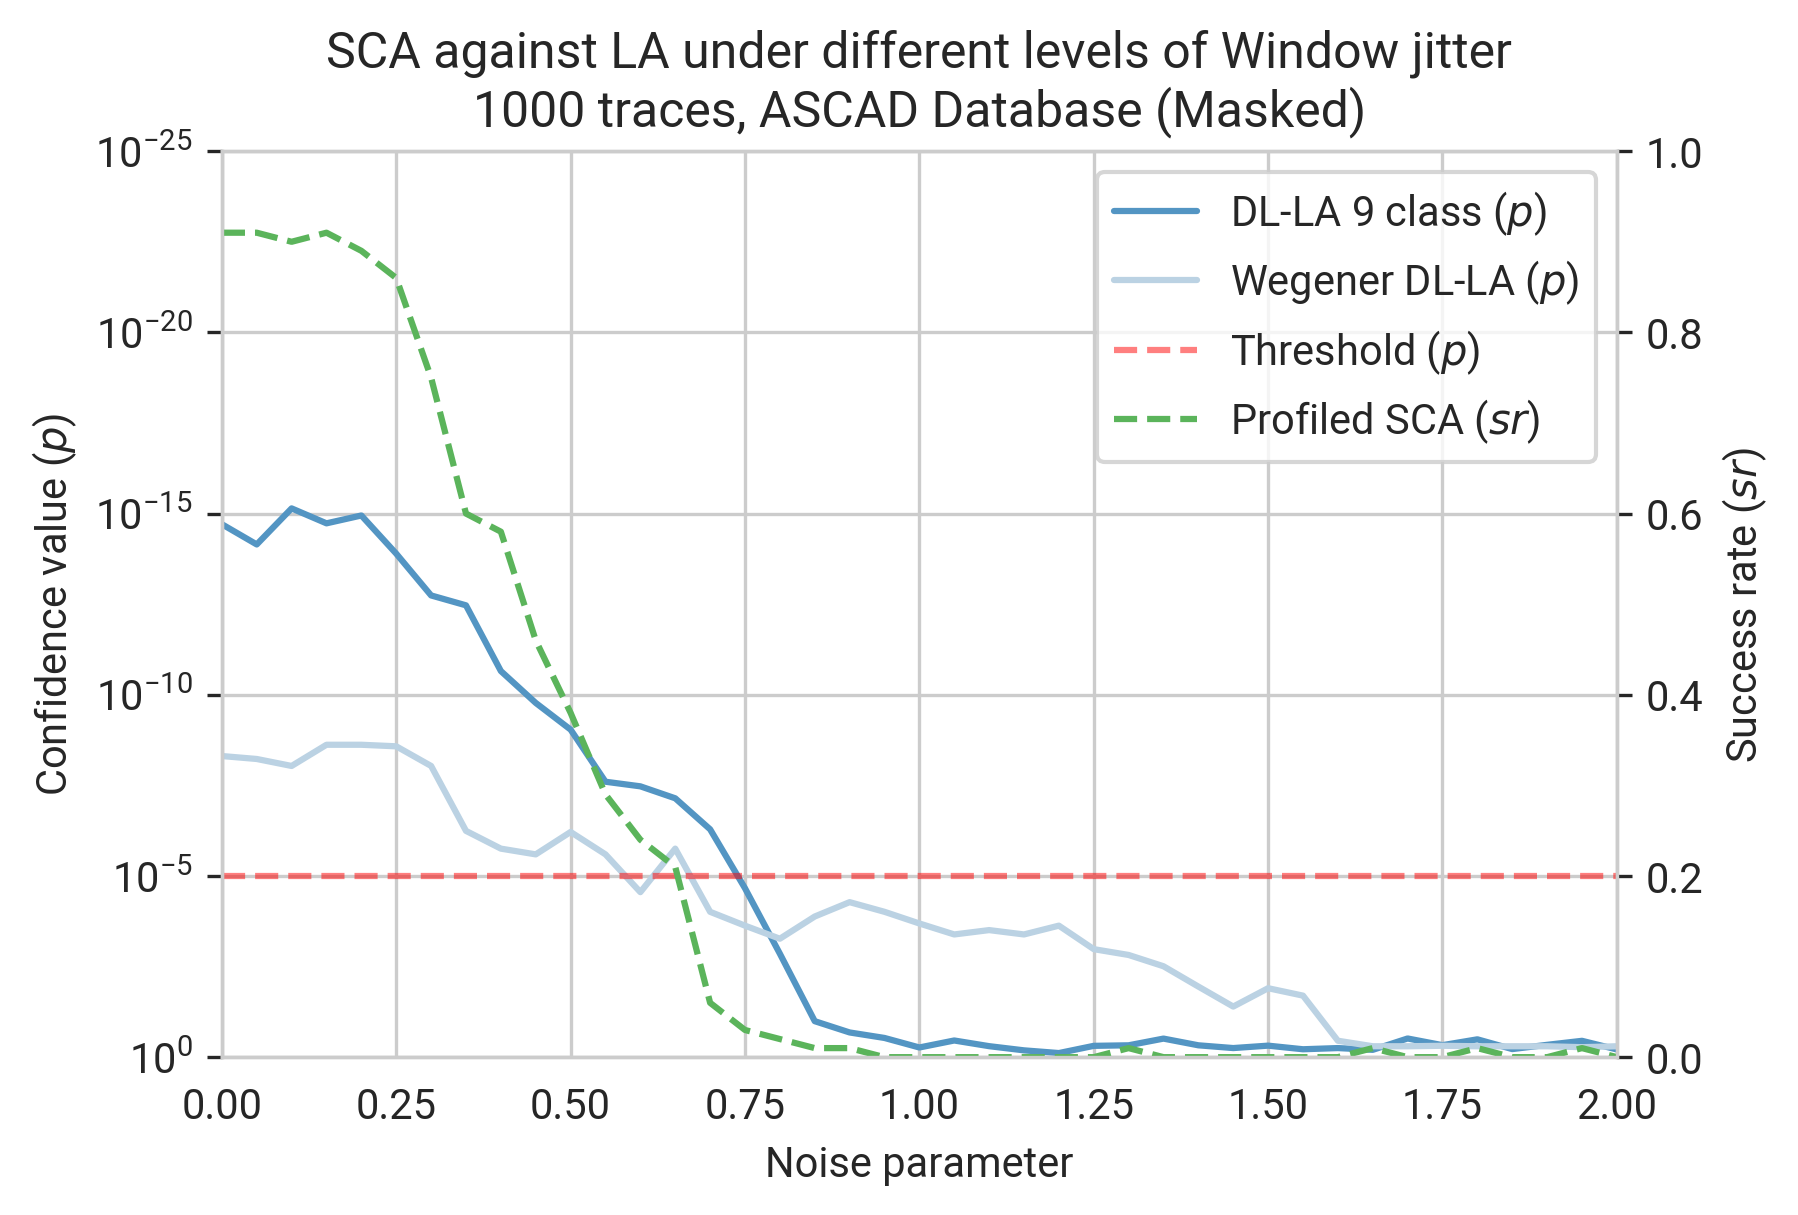

In [143]:
G = plot(Database.ascad, PollutionType.desync, 2, False)

store_sns(G, "sca-sr-ascad-desync")

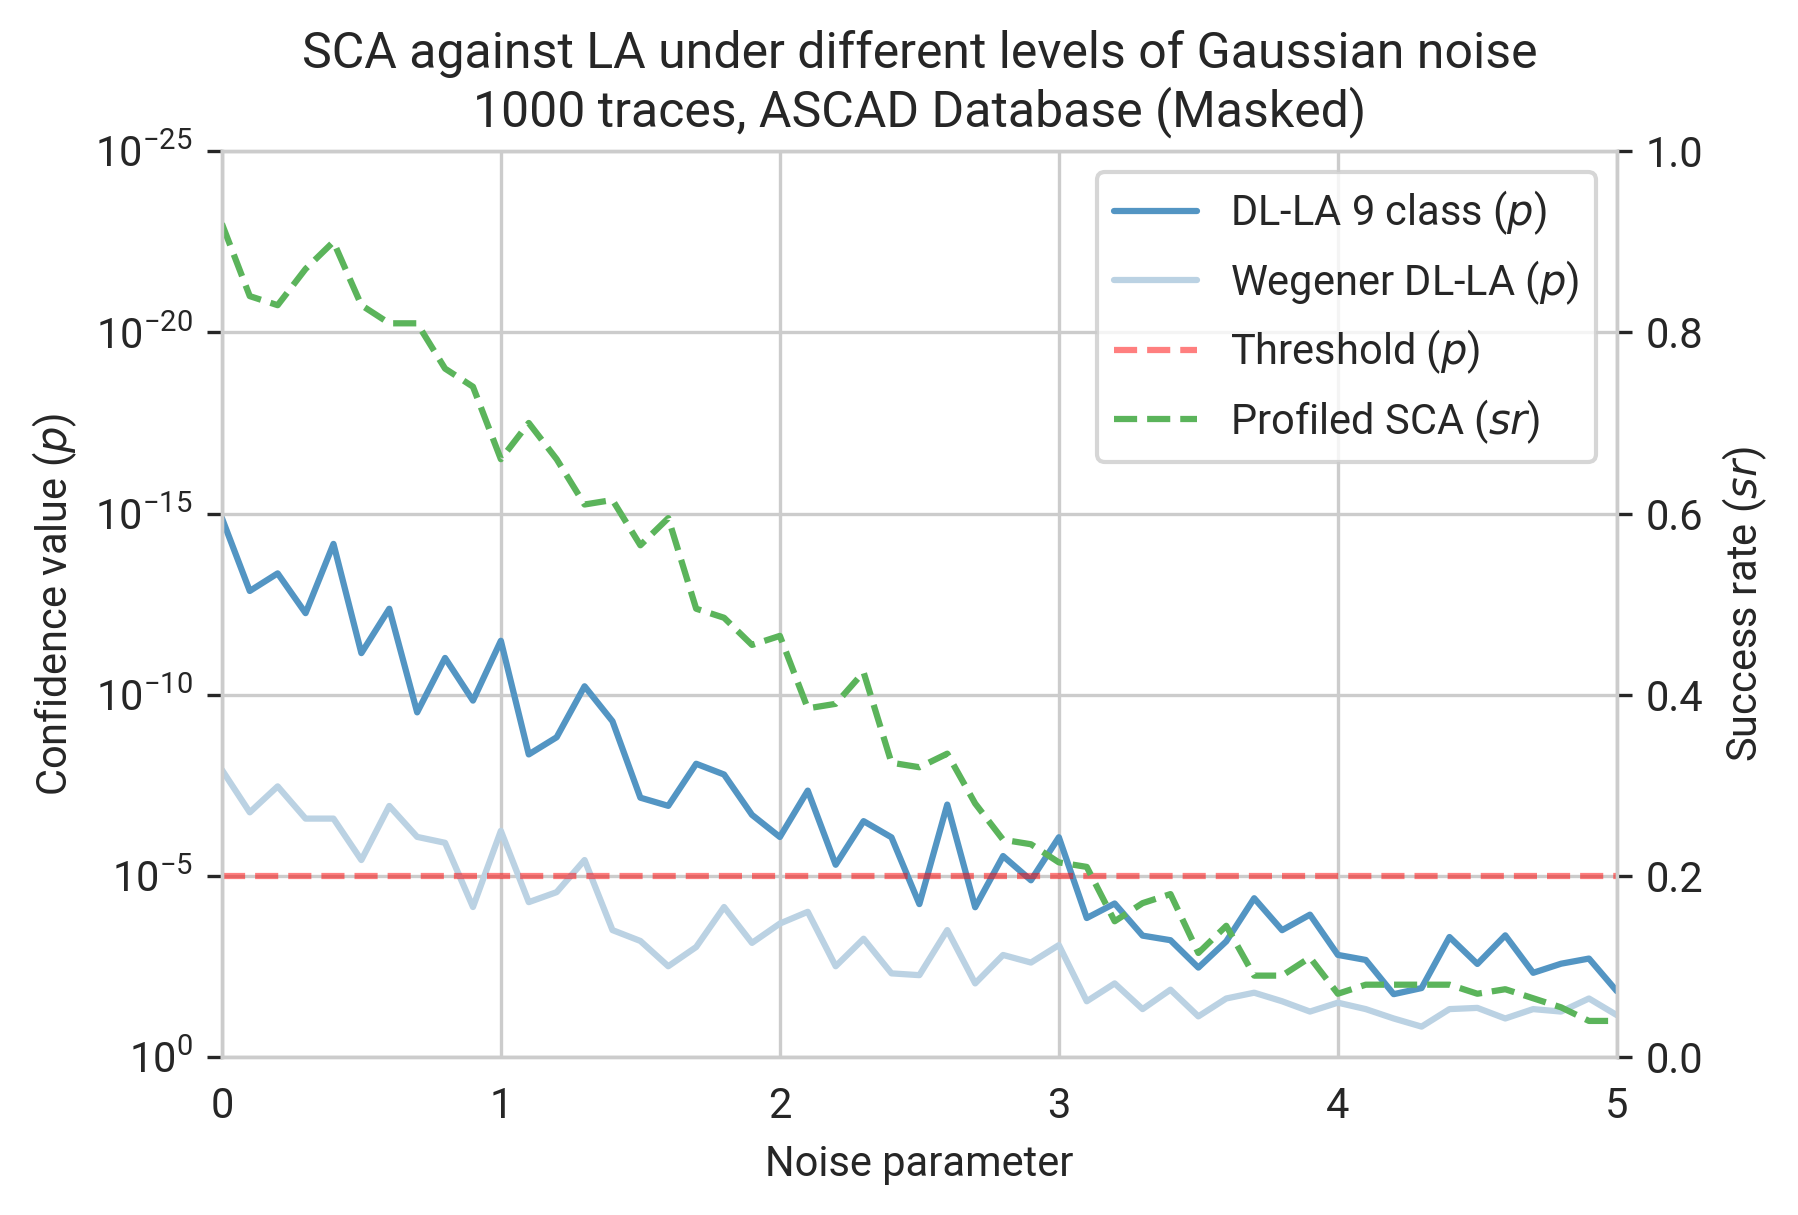

In [144]:
G = plot(Database.ascad, PollutionType.gauss, 5, False)

store_sns(G, "sca-sr-ascad-gauss")

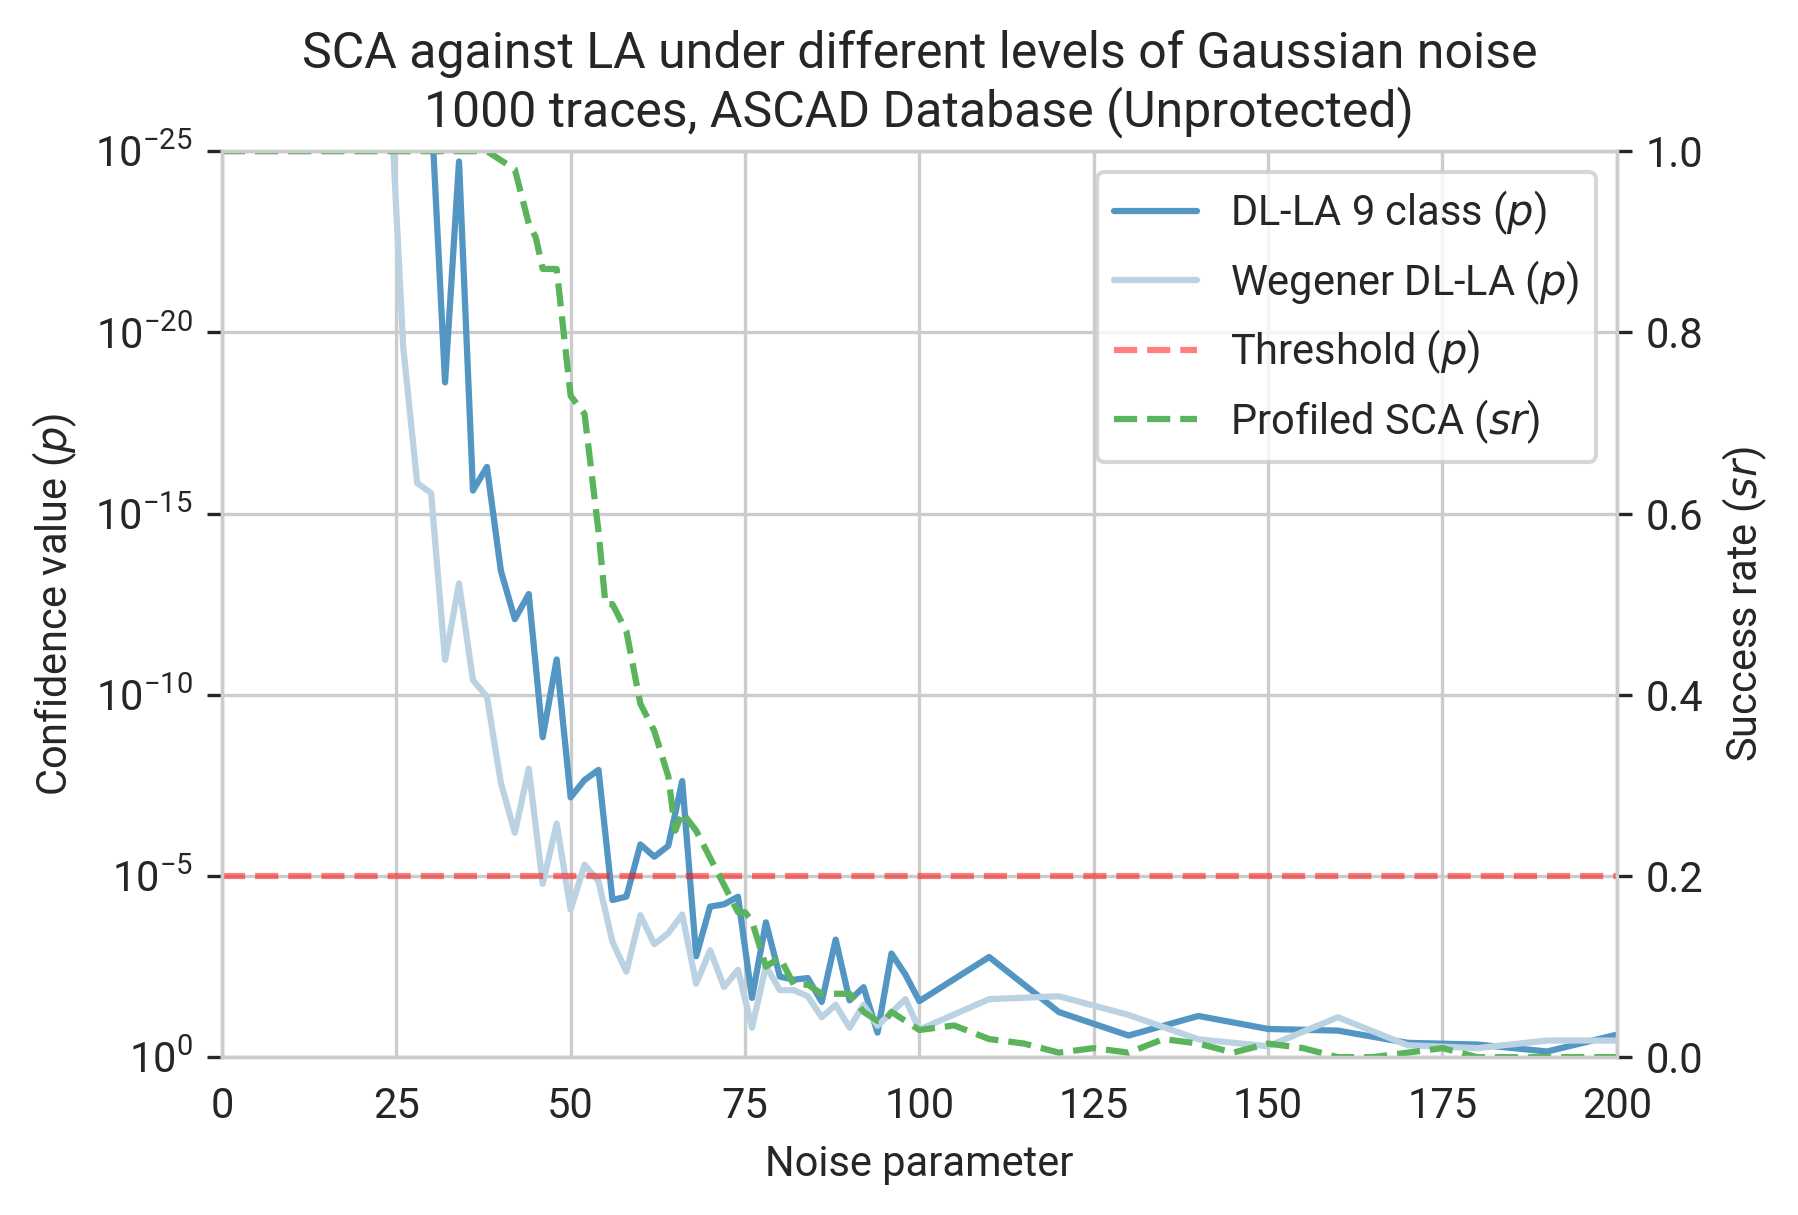

In [145]:
G = plot(Database.ascad_none, PollutionType.gauss, 200, False)

store_sns(G, "sca-sr-ascad-none-gauss")

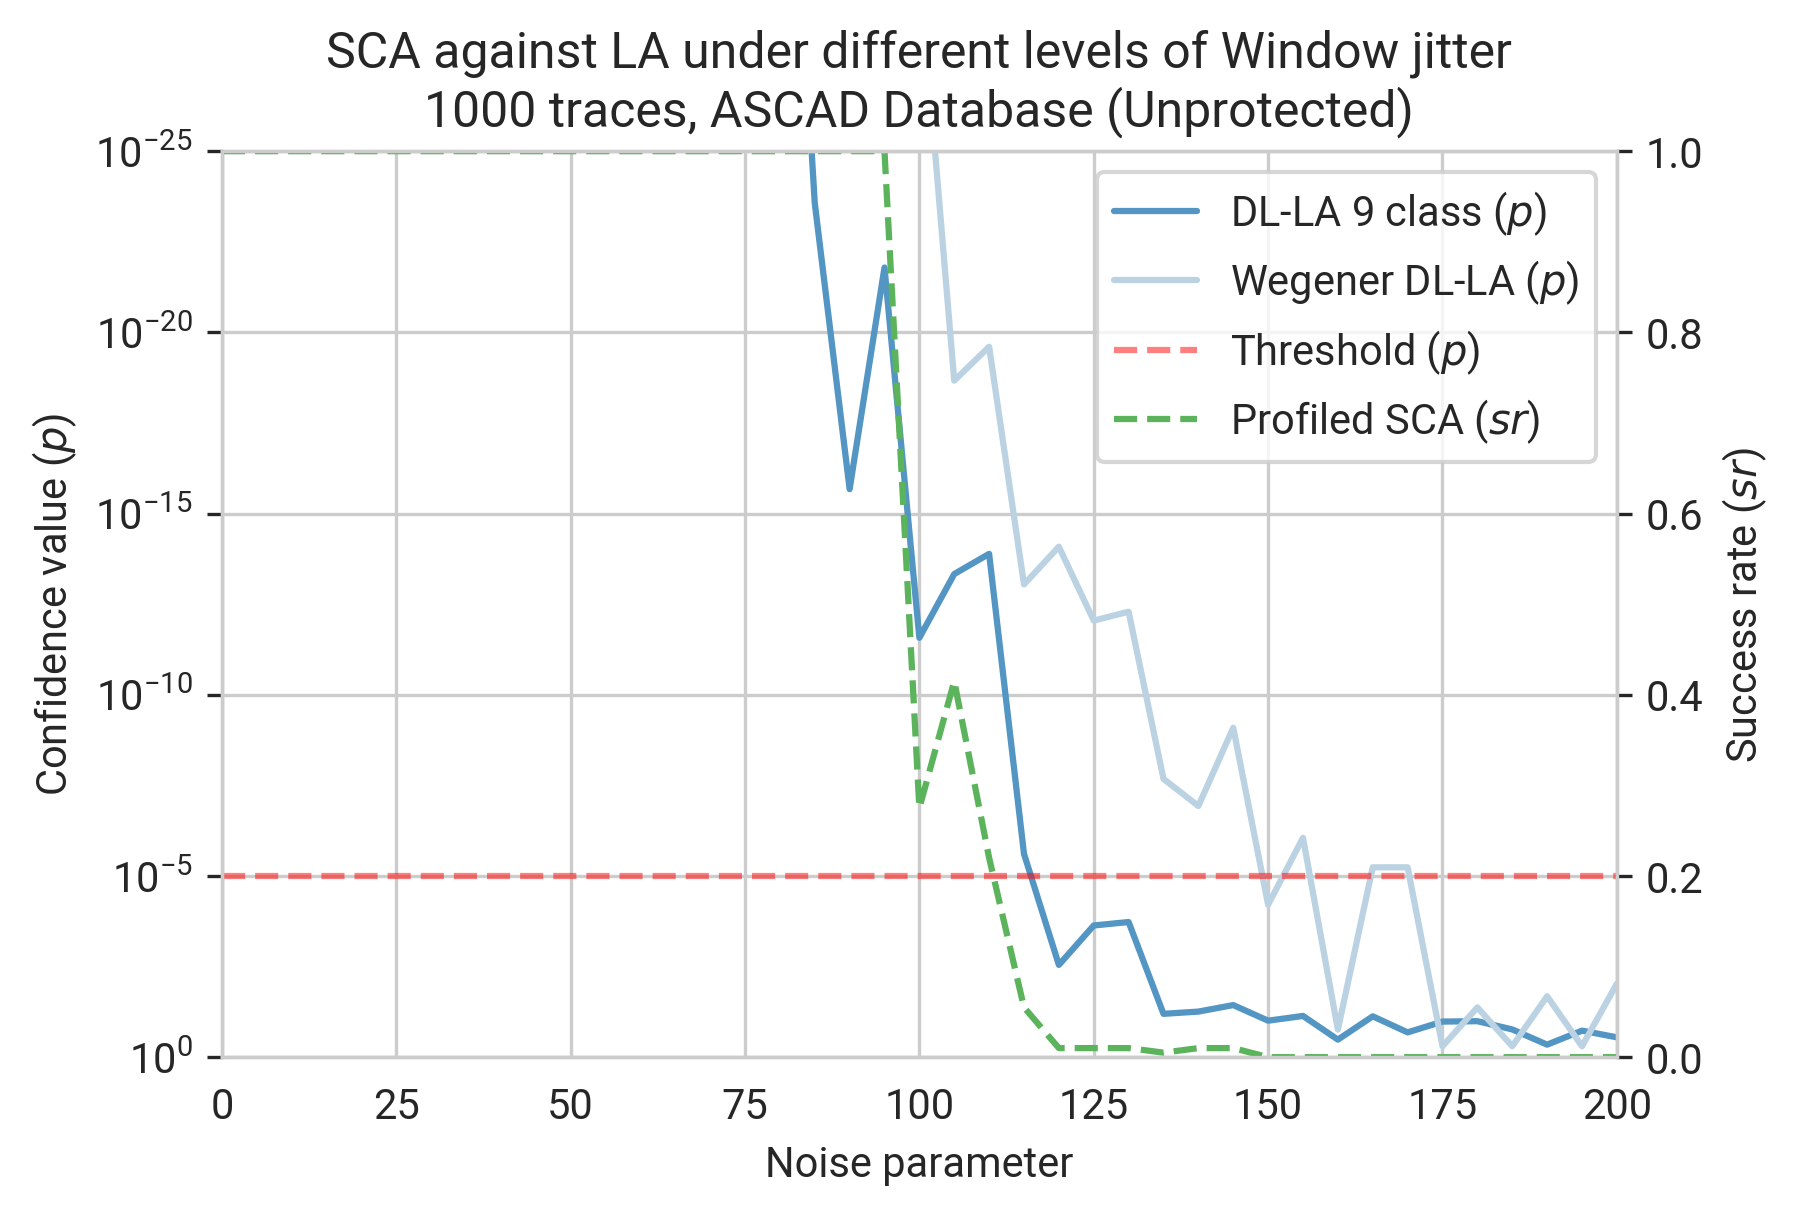

In [146]:
G = plot(Database.ascad_none, PollutionType.desync, 200, False)

store_sns(G, "sca-sr-ascad-none-desync")